# Kinetic energy distribution

*Note: This notebook can be run locally by cloning the*
[Github repository](https://github.com/shirtsgroup/physical_validation).
*The notebook is located in* `doc/examples/kinetic_energy_distribution.ipynb`. *Be aware
that probabilistic quantities such as error estimates based on bootstrapping
will differ when repeating the analysis.*

In [1]:
# enable plotting in notebook
%matplotlib notebook

The results imported here are the time series of kinetic and potential energy from example simulations, which are
stored in another Python file. In real-world usage, the results would
either come from the Python interface of the simulation package, from
flat files containing the results, or from package-specific parsers. See
[SimulationData](../simulation_data.rst)
for more details.

In [2]:
from simulation_results import example_simulations

import physical_validation

In this example, we will check the distributions of two simulations of 900 water molecules simulated under NVT conditions at 298.15K.
One simulation used velocity-rescale temperature coupling, the other used Berendsen temperature coupling.

In [3]:
simulation_vrescale = example_simulations.get(
    "900 water molecules, NVT at 298K with v-rescale thermostat"
)
simulation_berendsen = example_simulations.get(
    "900 water molecules, NVT at 298K with Berendsen thermostat"
)

First, we will create the object containing system information.
The example system used in both simulations consists of 900 water molecules which are fully constrained.
For the kinetic energy distribution check, we only need information about the
complete system (i.e. no per-molecule or per-atom information) so we will only
fill these.

In [4]:
num_molecules = 900
system_data = physical_validation.data.SystemData(
    # Each water molecule has three atoms
    natoms=num_molecules * 3,
    # Each molecule has three constraints
    nconstraints=num_molecules * 3,
    # In this simulation, translational center of mass motion was removed
    ndof_reduction_tra=3,
    # Rotational center of mass motion was not removed
    ndof_reduction_rot=0,
)

Next, we will create the ensemble information:

In [5]:
ensemble_data = physical_validation.data.EnsembleData(
    ensemble="NVT",
    natoms=num_molecules * 3,
    volume=3.01125 ** 3,
    temperature=298.15,
)

Now we will create the simulation data objects which we will feed to the physical validation tests.

In [6]:
simulation_data_vrescale = physical_validation.data.SimulationData(
    # Example simulations were performed using GROMACS
    units=physical_validation.data.UnitData.units("GROMACS"),
    system=system_data,
    ensemble=ensemble_data,
    observables=physical_validation.data.ObservableData(
        # This test requires only the kinetic energy
        kinetic_energy=simulation_vrescale["kinetic energy"]
    ),
)
simulation_data_berendsen = physical_validation.data.SimulationData(
    # Example simulations were performed using GROMACS
    units=physical_validation.data.UnitData.units("GROMACS"),
    system=system_data,
    ensemble=ensemble_data,
    observables=physical_validation.data.ObservableData(
        # This test requires only the kinetic energy
        kinetic_energy=simulation_berendsen["kinetic energy"]
    ),
)

We can now check the velocity-rescale temperature coupling, using first
the strict, then the non-strict kinetic energy distribution check.
We are using `screen=True` to display a result plot on screen (see argument `filename` to print that same plot to file).

After equilibration, decorrelation and tail pruning, 96.02% (4802 frames) of original Kinetic energy remain.


<IPython.core.display.Javascript object>


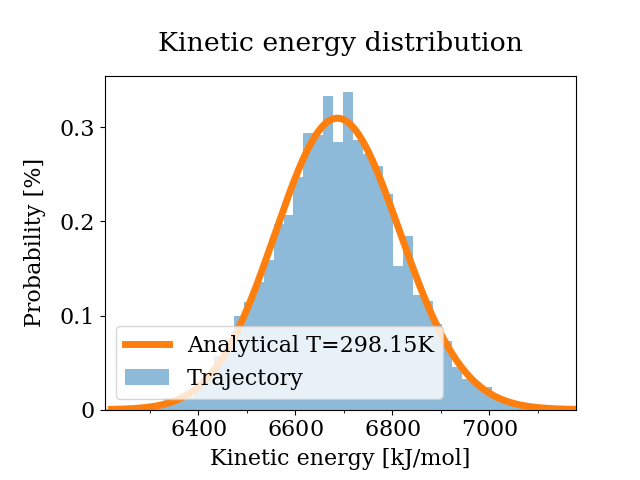

Kinetic energy distribution check (strict)
Kolmogorov-Smirnov test result: p = 0.898369
Null hypothesis: Kinetic energy is Maxwell-Boltzmann distributed


0.89836894520092

In [7]:
physical_validation.kinetic_energy.distribution(
    data=simulation_data_vrescale, strict=True, screen=True
)

The `strict` test prints and returns a p-value which indicates that the null hypothesis stands with high confidence. The printed figure confirms that the sampled and the analytical distribution are very similar.

The non-strict test confirms this result:

In [8]:
# We turn plotting off here (`screen=False`), because the plot is 
# identical to the one in the strict test
physical_validation.kinetic_energy.distribution(
    data=simulation_data_vrescale, strict=False, screen=False
)

After equilibration, decorrelation and tail pruning, 96.02% (4802 frames) of original Kinetic energy remain.
Kinetic energy distribution check (non-strict)
Analytical distribution (T=298.15 K):
 * mu: 6689.47 kJ/mol
 * sigma: 128.77 kJ/mol
Trajectory:
 * mu: 6688.12 +- 1.93 kJ/mol
   T(mu) = 298.09 +- 0.09 K
 * sigma: 128.70 +- 1.35 kJ/mol
   T(sigma) = 297.98 +- 3.12 K


(0.6978993132947631, 0.05371220622878283)

The non-strict test calculates the temperature of the mean and the width of the distribution. Analytically, we are expecting both to be close to 298.15K. The result confirms that the simulation behaves as expected, with both the calculated mean and variance being within one standard deviation of the analytical value. The returned tuple is the number of standard deviations the calculated mean and variance differ from the expected value - less than a standard deviations for the mean, and only about 0.05 standard deviations for the variance. Note that any deviation within about 2-3 standard deviations is usually considered as statistically insignificant.

We can now compare this to the Berendsen temperature coupling, using first
the strict, then the non-strict kinetic energy distribution check.

After equilibration, decorrelation and tail pruning, 95.96% (4799 frames) of original Kinetic energy remain.


<IPython.core.display.Javascript object>


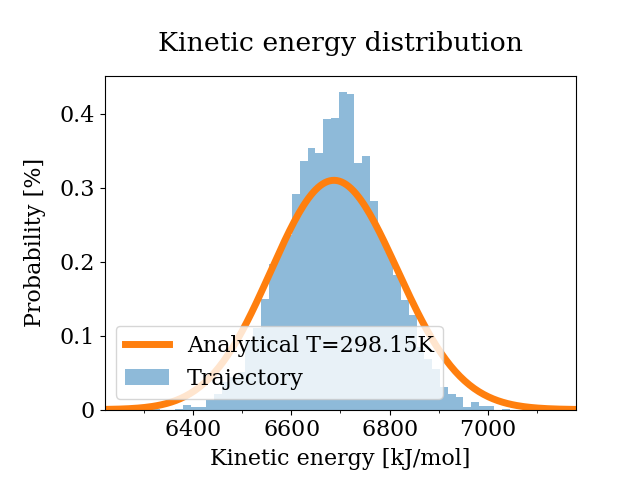

Kinetic energy distribution check (strict)
Kolmogorov-Smirnov test result: p = 1.85798e-17
Null hypothesis: Kinetic energy is Maxwell-Boltzmann distributed


1.8579783151867675e-17

In [9]:
physical_validation.kinetic_energy.distribution(
    data=simulation_data_berendsen, strict=True, screen=True
)

The calculated p-value means that the trajectory is _very_ unklikely to come from a Maxwell-Boltzmann distribution at 298.15K. Commonly, one would consider a p-value of less than 0.05 (5% confidence interval) a reasonable cut-off, which means that the test results make it easy to reject the null hypothesis that the kinetic energy samples the correct distribution. This does not come as a suprise, the Berendsen thermostat is known to keep the correct mean temperature, but not to sample the right distribution.

In [10]:
# We turn plotting off here (`screen=False`), because the plot is 
# identical to the one in the strict test
physical_validation.kinetic_energy.distribution(
    data=simulation_data_berendsen, strict=False, screen=False
)

After equilibration, decorrelation and tail pruning, 95.96% (4799 frames) of original Kinetic energy remain.
Kinetic energy distribution check (non-strict)
Analytical distribution (T=298.15 K):
 * mu: 6689.47 kJ/mol
 * sigma: 128.77 kJ/mol
Trajectory:
 * mu: 6690.21 +- 1.49 kJ/mol
   T(mu) = 298.18 +- 0.07 K
 * sigma: 98.81 +- 1.04 kJ/mol
   T(sigma) = 228.78 +- 2.41 K


(0.5011770465340951, 28.784482544312727)

The non-strict test confirms the conclusion from the strict test, but adds another explanation of the sampled distribution. The mean is found to be within about half a standard deviation of the expected value. The width of the sampled distribution, however, is what we would expect for a simulation at about 229K. This means that especially for simulations which rely on correct sampling of the tail regions, the Berendsen temperature coupling is likely to introduce artefacts. Again, the tuple returned here could be slightly different in different trials since no random seed was set.